In [1]:
import time
import psycopg2
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (cluster_utils,
                                            portfolio_utils as portfolio,
                                            lstm)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
date_start = '1995-01-01'
date_end = '2005-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
    limit 30
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,open
0,AB,1999-09-20 05:00:00,27.000000
1,ABC,1999-09-20 05:00:00,6.125000
2,ABT,1999-09-20 05:00:00,20.575147
3,ABM,1999-09-20 05:00:00,11.062500
4,ACY,1999-09-20 05:00:00,7.250000


### Clean data

In [3]:
def normalize(df, column='open', window_size=1000):
    df['open_min'] = df[column].rolling(window_size).min()
    df['open_max'] = df[column].rolling(window_size).max()
    df[column] = ((df[column] - df['open_min']) / (df['open_max'] - df['open_min']))
    return df

In [4]:
df['open_price'] = df['open']
df['open_min'], df['open_max'] = 0, 0

df = df.groupby('symbol').apply(normalize)
df = df[df['open'].notnull()]

In [5]:
df = cluster_utils.encode_one_hot(df, ['symbol'])

In [6]:
def sequence_data(df, column='open', length=100):
    dfs = []
    for offset in range(1, length, 1):
        df = df.join(df[column].shift(offset), rsuffix='_' + str(abs(offset)))
    return df

train_test = df.groupby('symbol').apply(sequence_data)


train_test = train_test.dropna()
train_test = train_test.sort_values(by='market_datetime')

print(train_test.shape)
train_test.head(10)

(1574, 114)


,symbol,market_datetime,open,open_price,open_min,open_max,symbol_A,symbol_AA,symbol_AB,symbol_ABC,...,open_90,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99
12237,AA,2004-02-03 06:00:00,0.574561,101.160000,54.000000,136.080000,0,1,0,0,...,0.354532,0.357091,0.362939,0.390351,0.365497,0.364035,0.381944,0.417763,0.374635,0.380117
12238,ABT,2004-02-03 06:00:00,0.496197,20.910091,14.354754,27.565912,0,0,0,0,...,0.470208,0.464824,0.464824,0.515075,0.509691,0.511486,0.500000,0.513640,0.489950,0.486001
12241,ABC,2004-02-03 06:00:00,0.620840,13.840000,3.078125,20.412500,0,0,0,1,...,0.617551,0.610050,0.606511,0.598018,0.644020,0.658882,0.672328,0.676999,0.666384,0.670913
12243,AB,2004-02-03 06:00:00,0.412857,37.950000,23.500000,58.500000,0,0,1,0,...,0.362857,0.364000,0.358571,0.368571,0.359714,0.353143,0.340571,0.347143,0.327143,0.302286
12244,ABM,2004-02-03 06:00:00,0.817239,17.820000,10.531250,19.450000,0,0,0,0,...,0.511668,0.488464,0.514832,0.530653,0.525379,0.557020,0.547528,0.509558,0.530653,0.514832
12248,ABEV,2004-02-03 06:00:00,0.774504,0.978800,0.432000,1.138000,0,0,0,0,...,0.611898,0.640227,0.669122,0.682720,0.637394,0.651558,0.661756,0.657224,0.684419,0.708215
12250,AB,2004-02-04 06:00:00,0.410000,37.850000,23.500000,58.500000,0,0,1,0,...,0.347143,0.362857,0.364000,0.358571,0.368571,0.359714,0.353143,0.340571,0.347143,0.327143
12251,ABC,2004-02-04 06:00:00,0.622859,13.875000,3.078125,20.412500,0,0,0,1,...,0.615004,0.617551,0.610050,0.606511,0.598018,0.644020,0.658882,0.672328,0.676999,0.666384
12254,AA,2004-02-04 06:00:00,0.570175,100.800000,54.000000,136.080000,0,1,0,0,...,0.349050,0.354532,0.357091,0.362939,0.390351,0.365497,0.364035,0.381944,0.417763,0.374635
12255,ABT,2004-02-04 06:00:00,0.516117,21.173262,14.354754,27.565912,0,0,0,0,...,0.432520,0.470208,0.464824,0.464824,0.515075,0.509691,0.511486,0.500000,0.513640,0.489950


### Train lstm

In [7]:
cols_to_ignore = ['symbol', 'market_datetime', 'open', 'open_min', 'open_max', 'open_price']

data_size = int(round(len(train_test)/2, -2))

train = train_test.head(data_size)
test = train_test.tail(int(data_size/2))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:179: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.dropout, self.training, self.bidirectional, self.batch_first)


Batch 1, Epoch 0, Loss 418.10693359375
Batch 1, Epoch 50, Loss 62.27700424194336
Batch 1, Epoch 100, Loss 46.099998474121094
Batch 1, Epoch 150, Loss 37.659114837646484
Batch 1, Epoch 200, Loss 31.729455947875977
Batch 1, Epoch 250, Loss 28.285221099853516
Batch 1, Epoch 300, Loss 26.418834686279297
Batch 1, Epoch 350, Loss 24.343082427978516
Batch 1, Epoch 400, Loss 22.278247833251953
Batch 1, Epoch 450, Loss 20.469863891601562


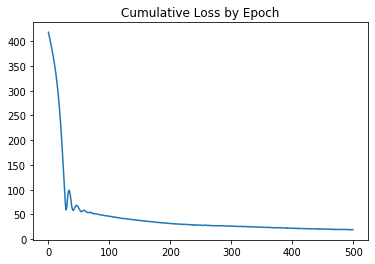

In [8]:
model = lstm.TorchLSTM(
    train_x=train.drop(cols_to_ignore, axis=1),
    train_y=train['open'],
    test_x=test.drop(cols_to_ignore, axis=1),
    test_y=test['open'],
    n_layers=2,
    n_training_batches=1,
    n_epochs=500,
    hidden_shape=1000,
    dropout=0.1,
    learning_rate=.0001,
    seed=44
)

model.fit()
prediction = model.prediction_df

In [9]:
res = test[cols_to_ignore].join(prediction)
res.head()

,symbol,market_datetime,open,open_min,open_max,open_price,symbol_A,symbol_AA,symbol_AB,symbol_ABC,...,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99,prediction
14747,AB,2004-10-11 05:00:00,0.369143,23.500000,58.500000,36.420000,0,0,1,0,...,0.290000,0.286286,0.282857,0.290000,0.275714,0.271429,0.268857,0.257143,0.248571,0.347572
14759,A,2004-10-12 05:00:00,0.199120,7.653791,48.283262,15.743920,1,0,0,0,...,0.218432,0.213227,0.212649,0.204552,0.201280,0.194879,0.196586,0.195021,0.204836,0.213378
14761,AA,2004-10-12 05:00:00,0.551901,54.000000,136.080000,99.299997,0,1,0,0,...,0.491594,0.486111,0.486111,0.493421,0.493421,0.449561,0.445906,0.427632,0.427632,0.568838
14757,AB,2004-10-12 05:00:00,0.385714,23.500000,58.500000,37.000000,0,0,1,0,...,0.298571,0.290000,0.286286,0.282857,0.290000,0.275714,0.271429,0.268857,0.257143,0.349688
14760,ABM,2004-10-12 05:00:00,0.886499,12.530000,20.900000,19.950000,0,0,0,0,...,0.948882,0.929712,0.952716,0.942721,0.961814,0.910899,0.955449,0.965769,0.879556,0.937536


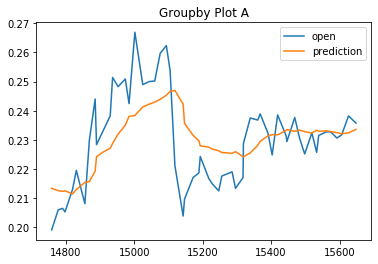

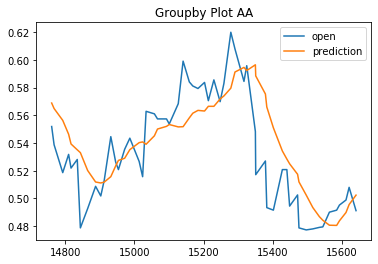

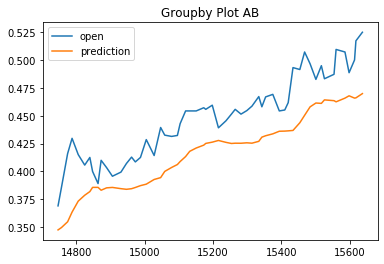

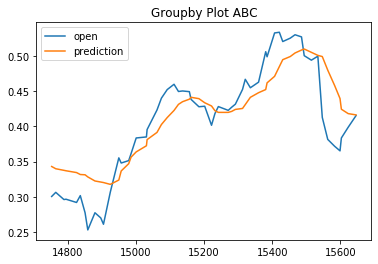

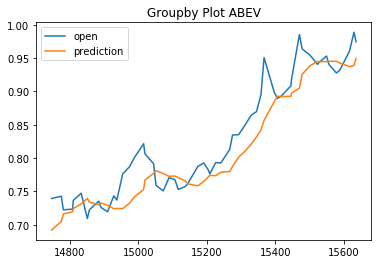

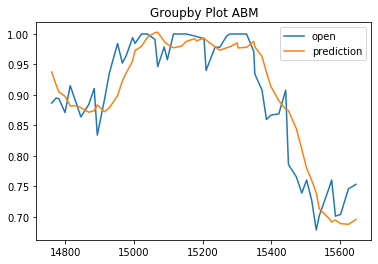

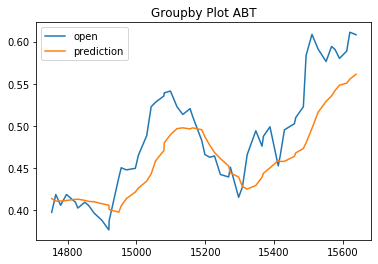

In [10]:
cluster_utils.plot_groupby(res, 'symbol', lines=['open', 'prediction'])

In [11]:
# Calculate prior price and prediction
res['open_price_prior'] = (res['open_1'] * (res['open_max'] - res['open_min'])) + res['open_min']
res['open_pred'] = (res['prediction'] * (res['open_max'] - res['open_min'])) + res['open_min']
res['profit_pred'] = abs(res['open_pred'] - res.groupby('symbol').shift()['open_price'])

# Determine trade directions
res['trade'] = 'neutral'
res.loc[res['prediction'] > res['open_1'], 'trade'] = 'long'
res.loc[res['prediction'] < res['open_1'], 'trade'] = 'short'

# Calculate profits
res['profit'] = 0
res.loc[res['trade']=='long', 'profit'] = res['open_price'] - res['open_price_prior']
res.loc[res['trade']=='short', 'profit'] = res['open_price_prior'] - res['open_price']

res[['market_datetime', 'symbol', 'open', 'prediction', 'open_price', 
     'open_price_prior', 'open_pred', 'profit_pred', 'profit', 'trade']].tail(10)

,market_datetime,symbol,open,prediction,open_price,open_price_prior,open_pred,profit_pred,profit,trade
15621,2004-12-30 06:00:00,AA,0.508041,0.495616,95.699997,94.950000,94.680160,0.269840,-0.749997,short
15618,2004-12-30 06:00:00,AB,0.517143,0.466005,41.600000,41.000000,39.810187,1.189813,-0.600000,short
15623,2004-12-30 06:00:00,ABC,0.398793,0.418147,14.500000,14.350000,14.690339,0.340339,0.150000,long
15647,2004-12-31 06:00:00,ABM,0.753074,0.695427,19.880000,19.810000,19.317371,0.492629,-0.070000,short
15635,2004-12-31 06:00:00,ABEV,0.974504,0.949403,1.120000,1.130000,1.102278,0.027722,0.010000,short
15637,2004-12-31 06:00:00,AB,0.524857,0.469821,41.870000,41.600000,39.943726,1.656274,-0.270000,short
15638,2004-12-31 06:00:00,ABT,0.608187,0.561238,22.436480,22.474760,21.821842,0.652918,0.038280,short
15641,2004-12-31 06:00:00,AA,0.491228,0.502428,94.320000,95.699997,95.239260,0.460737,1.379997,short
15646,2004-12-31 06:00:00,ABC,0.415316,0.416328,14.662500,14.500000,14.672455,0.172455,0.162500,long
15648,2004-12-31 06:00:00,A,0.235739,0.233610,17.231760,17.331903,17.145250,0.186653,0.100143,short


In [12]:
kwargs = {"profit": 'profit'} 
res = res.groupby('symbol').apply(portfolio.get_estimated_loss, **kwargs)

res['kelly'] = portfolio.kelly_criterion(res['profit_pred'], 
                                         res['estimated_loss'], 
                                         res['profit_rate'])

res = res.dropna()
res.tail(10)

,symbol,market_datetime,open,open_min,open_max,open_price,symbol_A,symbol_AA,symbol_AB,symbol_ABC,...,open_99,prediction,open_price_prior,open_pred,profit_pred,trade,profit,profit_rate,estimated_loss,kelly
15621,AA,2004-12-30 06:00:00,0.508041,54.000000,136.080000,95.699997,0,1,0,0,...,0.440424,0.495616,94.950000,94.680160,0.269840,short,-0.749997,0.535714,0.959999,-1.116058
15618,AB,2004-12-30 06:00:00,0.517143,23.500000,58.500000,41.600000,0,0,1,0,...,0.261429,0.466005,41.000000,39.810187,1.189813,short,-0.600000,0.368421,0.300000,0.209174
15623,ABC,2004-12-30 06:00:00,0.398793,10.578125,20.412500,14.500000,0,0,0,1,...,0.408016,0.418147,14.350000,14.690339,0.340339,long,0.150000,0.464286,0.102500,0.302944
15647,ABM,2004-12-31 06:00:00,0.753074,12.530000,22.290000,19.880000,0,0,0,0,...,0.725575,0.695427,19.810000,19.317371,0.492629,short,-0.070000,0.438596,0.200000,0.210675
15635,ABEV,2004-12-31 06:00:00,0.974504,0.432000,1.138000,1.120000,0,0,0,0,...,0.560907,0.949403,1.130000,1.102278,0.027722,short,0.010000,0.526316,0.009200,0.369115
15637,AB,2004-12-31 06:00:00,0.524857,23.500000,58.500000,41.870000,0,0,1,0,...,0.265714,0.469821,41.600000,39.943726,1.656274,short,-0.270000,0.362069,0.285000,0.252298
15638,ABT,2004-12-31 06:00:00,0.608187,14.474377,27.565912,22.436480,0,0,0,0,...,0.316155,0.561238,22.474760,21.821842,0.652918,short,0.038280,0.456140,0.153117,0.328599
15641,AA,2004-12-31 06:00:00,0.491228,54.000000,136.080000,94.320000,0,1,0,0,...,0.446272,0.502428,95.699997,95.239260,0.460737,short,1.379997,0.543860,0.990000,-0.436264
15646,ABC,2004-12-31 06:00:00,0.415316,10.578125,20.412500,14.662500,0,0,0,1,...,0.414594,0.416328,14.500000,14.672455,0.172455,long,0.162500,0.473684,0.102500,0.160864
15648,A,2004-12-31 06:00:00,0.235739,7.653791,48.283262,17.231760,1,0,0,0,...,0.213908,0.233610,17.331903,17.145250,0.186653,short,0.100143,0.578947,0.264664,-0.018082


In [13]:
res['half_kelly'] = res['kelly']/2
trades, budget = portfolio.greedy_kelly(
    res,
    price='open_price_prior',
    profit='profit',
    kelly='half_kelly'
)

Annualized P/L 0.571187


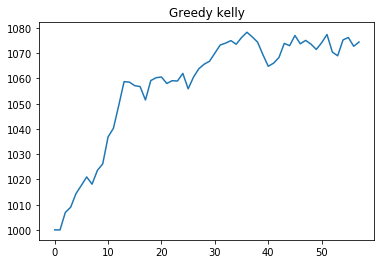

,symbol,market_datetime,open,open_min,open_max,open_price,symbol_A,symbol_AA,symbol_AB,symbol_ABC,...,profit_pred,trade,profit,profit_rate,estimated_loss,kelly,half_kelly,position,n_shares,trade_profit
14766,ABT,2004-10-13 05:00:00,0.418494,14.474377,27.565912,19.953108,0,0,0,0,...,0.175713,long,0.277525,1.000000,0.205751,1.000000,0.500000,491.889575,25,6.938125
14780,ABT,2004-10-14 05:00:00,0.405702,14.474377,27.565912,19.785636,0,0,0,0,...,0.101887,short,0.167472,1.000000,0.167472,1.000000,0.500000,498.827700,25,4.186800
14789,ABC,2004-10-14 05:00:00,0.296039,10.156250,20.412500,13.192500,0,0,0,1,...,0.320795,long,-0.105000,0.666667,0.060000,0.604321,0.302161,292.545000,22,-2.310000
14791,A,2004-10-14 05:00:00,0.206514,7.653791,48.283262,16.044349,1,0,0,0,...,0.258950,long,0.021459,0.666667,0.278970,0.307563,0.153782,144.206010,9,0.193131
14810,AA,2004-10-15 05:00:00,0.531798,54.000000,136.080000,97.650000,0,1,0,0,...,2.272084,long,1.080000,0.500000,1.290002,0.216119,0.108060,96.570000,1,1.080000


In [14]:
annualized_return = portfolio.annualized_return(
    budget[0], 
    budget[-1], 
    len(budget))
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('Greedy kelly')
plt.plot(budget)
plt.show()

trades.head()

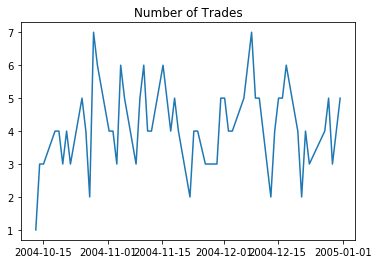

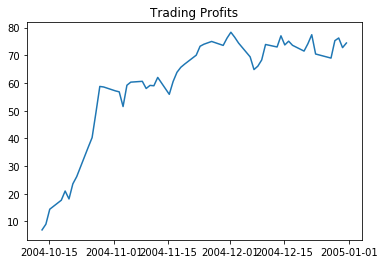

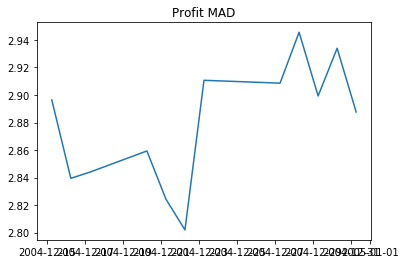

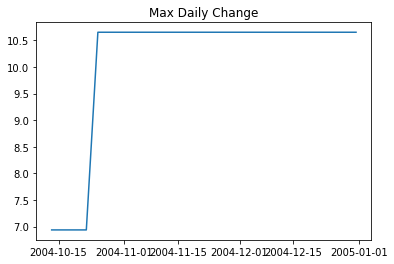

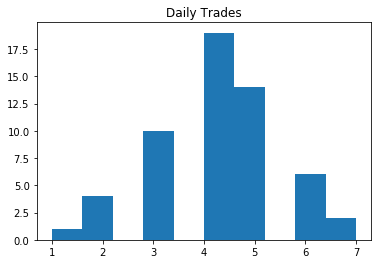

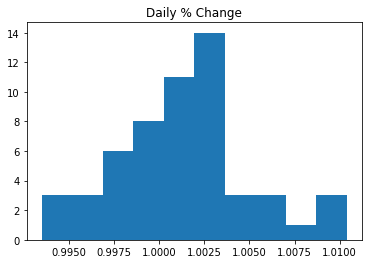

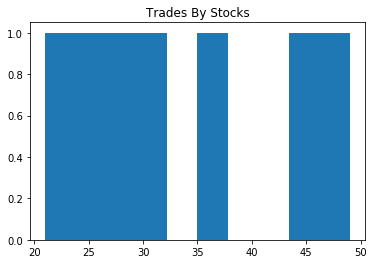

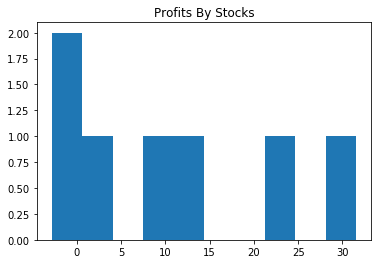

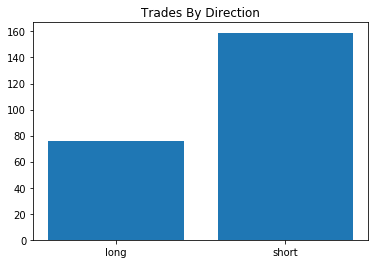

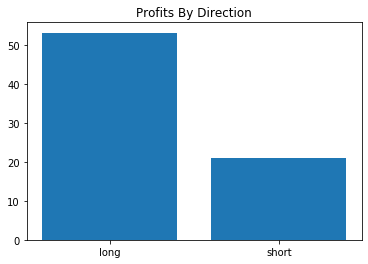

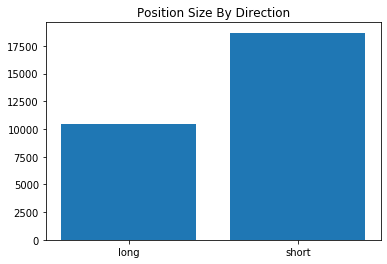

symbol    profit           profit_pred           trade  \
                    nunique       sum      mean         sum      mean count   
market_datetime                                                               
2004-10-13 05:00:00       1  0.277525  0.277525    0.175713  0.175713     1   
2004-10-14 05:00:00       3  0.083931  0.027977    0.681633  0.227211     3   
2004-10-15 05:00:00       3  1.252472  0.417491    2.766169  0.922056     3   
2004-10-18 05:00:00       4  0.716858  0.179215    1.991231  0.497808     4   
2004-10-19 05:00:00       4  0.779089  0.194772    1.812625  0.453156     4   

                       position trade_profit       mad  
                            sum          sum            
market_datetime                                         
2004-10-13 05:00:00  491.889575     6.938125  0.000000  
2004-10-14 05:00:00  935.578710     2.069931  1.217048  
2004-10-15 05:00:00  947.408400     5.401800  1.010871  
2004-10-18 05:00:00  839.952312     3.252015  1.049016  
2004-10-19 05:00:00  575.574395     3.323602  1.013911

In [15]:
daily, stocks, trades = portfolio.portfolio_performance(trades)
daily.head()

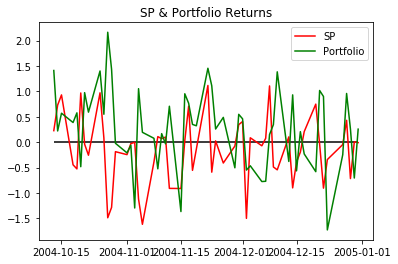

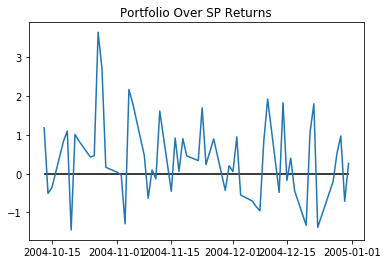

,market_datetime,sp_return,day_date,portfolio_return
0,2004-10-13,0.226794,2004-10-13,1.410505
1,2004-10-14,0.730045,2004-10-14,0.221246
2,2004-10-15,0.930273,2004-10-15,0.570166
3,2004-10-18,-0.445025,2004-10-18,0.387167
4,2004-10-19,-0.525182,2004-10-19,0.577441


In [16]:
comp = portfolio.sp_comparison(daily, date_start=date_start, date_end=date_end)
comp.head()